# Running FaIR

We will run FaIR using an SR1.5-like setup, with a few changes to reflect our updated knowledge. In SR1.5 we used v1.3.4 but the interface and setup will work exactly the same in v1.6.2.

In [1]:
import glob
from multiprocessing import Pool
import os
import sys

from climateforcing.utils import check_and_download
import matplotlib.pyplot as pl
import fair
from fair.forward import fair_scm
from fair.tools.magicc import scen_open
from fair.ancil import cmip6_solar, cmip6_volcanic, natural
from fair.RCPs import rcp3pd, rcp45
from fair.constants import lifetime
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from scmdata.run import ScmRun, run_append
from scmdata.netcdf import run_to_nc
from tqdm.notebook import tqdm
import xarray as xr

<IPython.core.display.Javascript object>

In [2]:
fair.__version__

'1.6.4'

In [3]:
version = "v4"
scen_file_dir = f"../output/{version}/"
output_dir = f"../output/{version}/fair/"

## Get FaIR SR1.5 config

A 10,000 member ensemble, trimmed down from a larger prior, is provided. This is the first 10,000 members of the large ensemble produced for [Smith et al. 2018](https://gmd.copernicus.org/articles/11/2273/2018/). 10,000 gives us around about 500-600 after constraining, which is why we use this number.

Here, we are going to constrain the 10,000 based on how well they reproduce temperature and CO2 concentrations in RCP4.5 until 2019.

In [4]:
config_dir = '../fair_sr15_params/'
ecstcr = np.load(config_dir+'ecstcr_recalc.npy')
d1 = np.load(config_dir+'d1_samples.npy')
d2 = np.load(config_dir+'d2_samples.npy')
rscale = np.load(config_dir+'r_samples.npy')
scale = np.load(config_dir+'forcing_scalings.npy')

### Other data sources and constants

In [12]:
startyear = 1765
endyear=2300
avi = rcp3pd.aviNOx_frac
ch4 = rcp3pd.fossilCH4_frac
nat = natural.Emissions.emissions
efficacy = np.ones(13); efficacy[9] = 3.0
sol = np.zeros((2501-startyear))
sol[:254] = cmip6_solar.Forcing.solar[:254]
vol = np.zeros((2501-startyear))
vol[:254] = cmip6_volcanic.Forcing.volcanic[:254]
tcr_dbl = np.log(2.0)/np.log(1.01)

In [6]:
fairfolder = "../FaIR_code/institutional_scenarios-master/"
check_and_download(
    'https://github.com/chrisroadmap/ar6/raw/main/data_input/observations/AR6%20FGD%20assessment%20time%20series%20-%20GMST%20and%20GSAT.xlsx',
    fairfolder + 'data/ar6_temperatures.xlsx'
)

In [7]:
temp_df = pd.read_excel(fairfolder + 'data/ar6_temperatures.xlsx', skiprows=1)
temp_gmst = temp_df['4-set mean'][:170].values

## Get scenarios

In [8]:
scens_to_run = [
    x for x in os.listdir(scen_file_dir) 
    if x.endswith('.SCEN') and 'BAU' not in x and 'STEPS' not in x
]
scens_to_run[0:10]

['scen_2030fact0.12_nz2040_ov-10000_meth0.25.SCEN',
 'scen_2030fact0.12_nz2040_ov-10000_meth0.5.SCEN',
 'scen_2030fact0.12_nz2040_ov-10000_meth0.75.SCEN',
 'scen_2030fact0.12_nz2040_ov-2500_meth0.25.SCEN',
 'scen_2030fact0.12_nz2040_ov-2500_meth0.5.SCEN',
 'scen_2030fact0.12_nz2040_ov-2500_meth0.75.SCEN',
 'scen_2030fact0.12_nz2040_ov-5000_meth0.25.SCEN',
 'scen_2030fact0.12_nz2040_ov-5000_meth0.5.SCEN',
 'scen_2030fact0.12_nz2040_ov-5000_meth0.75.SCEN',
 'scen_2030fact0.12_nz2040_ov-7500_meth0.25.SCEN']

In [9]:
scens_to_run = (
    [os.path.join(scen_file_dir, s) for s in scens_to_run] 
)
scens_to_run[0:10]

['../output/v4/scen_2030fact0.12_nz2040_ov-10000_meth0.25.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-10000_meth0.5.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-10000_meth0.75.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-2500_meth0.25.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-2500_meth0.5.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-2500_meth0.75.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-5000_meth0.25.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-5000_meth0.5.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-5000_meth0.75.SCEN',
 '../output/v4/scen_2030fact0.12_nz2040_ov-7500_meth0.25.SCEN']

In [10]:
emissions = {}
scen_labels = []
nscen = len(scens_to_run)

for scen in scens_to_run:
    name = os.path.split(scen)[1][:-5]
    scen_labels.append(name)
    emissions[name] = scen_open(scen)

## Sense check emissions plots

the purple one looks a bit odd - does MAGICC show this too?

Otherwise, the harmonization looks fine.

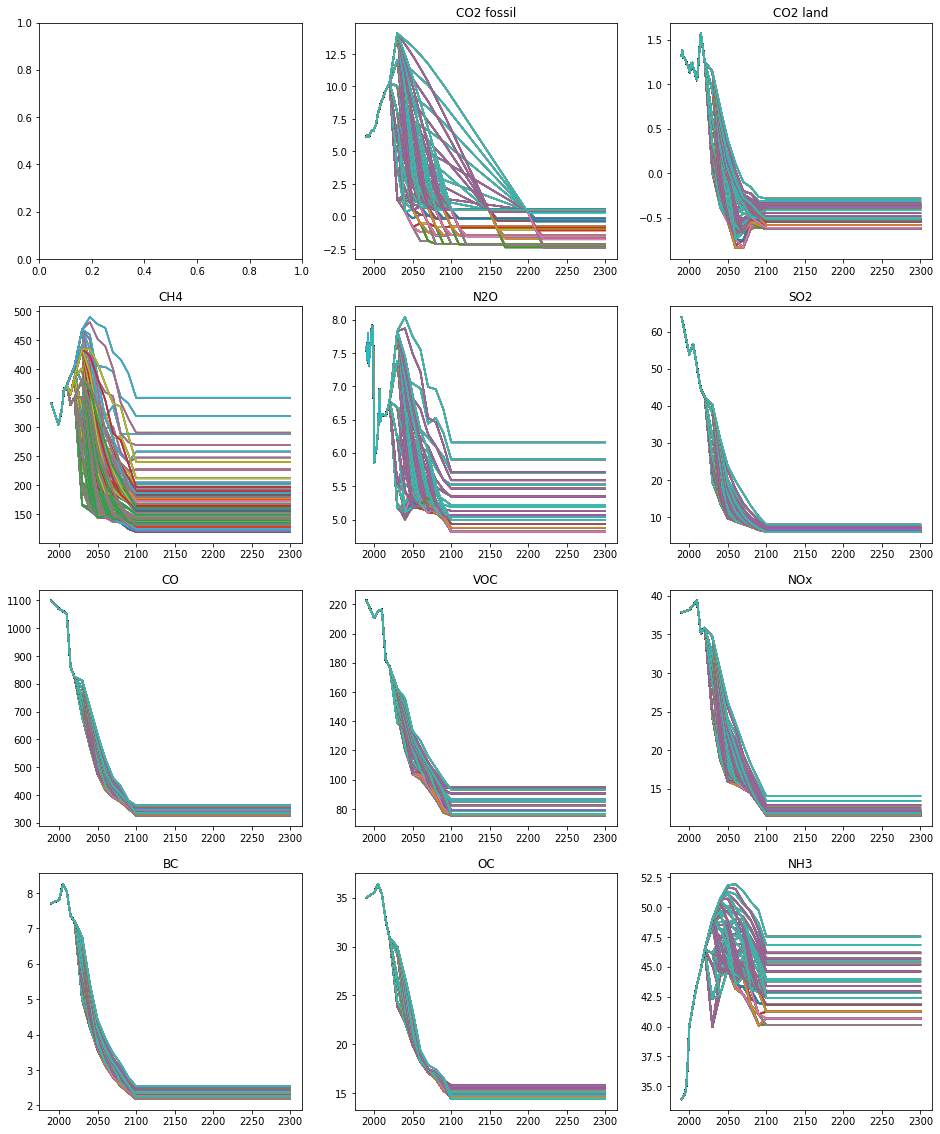

In [13]:
species = {
    1 : 'CO2 fossil',
    2 : 'CO2 land',
    3 : 'CH4',
    4 : 'N2O',
    5 : 'SO2',
    6 : 'CO',
    7 : 'VOC',
    8 : 'NOx',
    9 : 'BC',
    10 : 'OC',
    11 : 'NH3'
}

fig, ax = pl.subplots(4, 3, figsize=(16, 20))

for ispec, specie in species.items():
    row = ispec//3
    col = ispec%3
    for scen in scen_labels:
        ax[row, col].plot(np.arange(1990, endyear+1), emissions[scen][225:, ispec])
    ax[row, col].set_title(specie)

## Run 500 member ensemble in RCP4.5 for constraining

Constrain the results on both present-day CO2 concentrations assuming RCP4.5 emissions, and temperature. Eventually we can use a higher number to constrain

In [14]:
endyear_hist = 2019
nt = endyear_hist - startyear + 1
n = 500
Fscale = np.ones(13)
C = np.zeros((nt, n))
T = np.zeros((nt, n))
for ens in tqdm(range(n)):
    Fscale[1:12] = scale[ens,1:12]
    thisC, _, T[:, ens] = fair_scm(
        emissions = rcp45.Emissions.emissions[:nt, :],
        tcrecs = ecstcr[ens,::-1],
        F_volcanic = vol[:nt],
        F_solar = sol[:nt]+scale[ens,12],
        natural = nat[:nt,:],
        r0 = 35.0*rscale[ens,0],
        rt = 4.165*rscale[ens,1],
        rc = 0.019*rscale[ens,2],
        d = np.array([d2[ens], d1[ens]]),
        F2x = 3.71 * scale[ens,0],
        scale = Fscale,
        tcr_dbl = tcr_dbl,
        aviNOx_frac = avi[:nt],
        fossilCH4_frac = ch4[:nt],
        efficacy = efficacy,
        scaleHistoricalAR5 = False,
    )
    C[:, ens] = thisC[:, 0]

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\rlamboll\Anaconda3\envs\runfair\lib\site-packages\fair\gas_cycle\fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [16]:
# IPCC 2021 gives 2019 CO2 concentrations as 409.85 ppm
# we will allow +/- 2 ppm around this
accept_co2 = ((407.85 < C[-1, :]) & (C[-1, :] < 411.85))
valid_co2 = np.arange(n, dtype=int)[accept_co2]
np.sum(accept_co2)

83

In [17]:
# temperatures: follow IPCC AR6 constraining method
def rmse(obs, mod):
    return np.sqrt(np.sum((obs-mod)**2)/len(obs))

rmse_temp = np.zeros((n))
for i in range(n):
    rmse_temp[i] = rmse(temp_gmst, (T[85:255,i]-np.mean(T[85:136,i], axis=0)))
accept_temp=(rmse_temp<0.135)
valid_temp = np.arange(n, dtype=int)[accept_temp]
print(np.sum(accept_temp))

123


In [18]:
# this number of ensemble members pass both constraints
valid = np.arange(n, dtype=int)[(accept_temp & accept_co2)]
np.sum(accept_temp & accept_co2)

24

## Run constrained ensemble for each scenario

In [19]:
T_result = {}

endyear = 2300
nt = endyear - startyear + 1
for scen in tqdm(scen_labels):
    Fscale = np.ones(13)
    T_result[scen] = np.zeros((nt, len(valid)))
    for i, ens in tqdm(enumerate(valid), total=len(valid), leave=False, position=0):
        Fscale[1:12] = scale[ens,1:12]
        _, _, thisT = fair_scm(emissions[scen],
            tcrecs         = ecstcr[ens,::-1],
            F_volcanic     = vol[:nt],
            F_solar        = sol[:nt]+scale[ens,12],
            natural        = nat[:nt,:],
            r0             = 35.0*rscale[ens,0],
            rt             = 4.165*rscale[ens,1],
            rc             = 0.019*rscale[ens,2],
            d              = np.array([d2[ens], d1[ens]]),
            F2x            = 3.71 * scale[ens,0],
            scale          = Fscale,
            tcr_dbl        = tcr_dbl,
            aviNOx_frac    = avi[:nt],
            fossilCH4_frac = ch4[:nt],
            efficacy       = efficacy,
            scaleHistoricalAR5=False,
        )
        T_result[scen][:,i]      = thisT

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

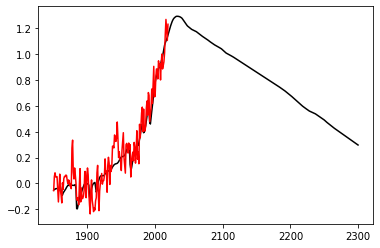

In [20]:
pl.plot(np.arange(1850, endyear+1), np.median(T_result[next(iter(T_result))] - T_result[next(iter(T_result))][230:250, :].mean(axis=0) + 0.85, axis=1)[85:], color='k');
pl.plot(np.arange(1850, 2020), temp_gmst-temp_gmst[145:165].mean() + 0.85, color='r')

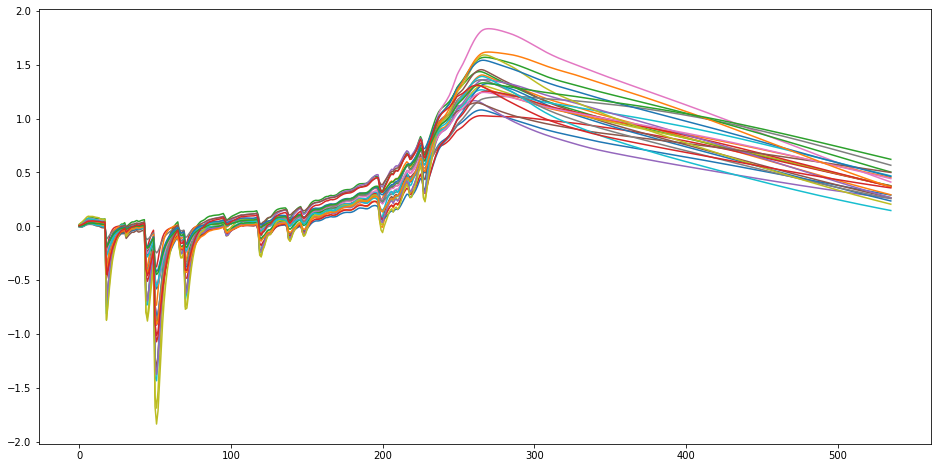

In [21]:
plt.figure(figsize=(16, 8))
pl.plot(T_result[next(iter(T_result))]);

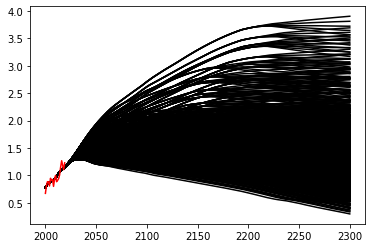

In [22]:
# median projection from each scenario
for scen in scen_labels:
    pl.plot(np.arange(2000, endyear+1), np.median(T_result[scen] - T_result[scen][230:250, :].mean(axis=0) + 0.85, axis=1)[235:], color='k');
pl.plot(np.arange(2000, 2020), temp_gmst[150:]-temp_gmst[145:165].mean() + 0.85, color='r')

In [23]:
np.median(T_result[scen] - T_result[scen][230:250, :].mean(axis=0) + 0.85, axis=1).shape

(536,)

In [24]:
T_result[next(iter(T_result))].shape

(536, 24)

## Save the results

In [25]:
t_result_df = []
for (key, val) in T_result.items():
    tmp = pd.DataFrame(val)
    tmp = tmp.transpose()
    tmp["scenario"] = key
    t_result_df.append(tmp)
t_result_df = pd.concat(t_result_df)

In [26]:
t_result_df = t_result_df.set_index("scenario")
t_result_df.columns = startyear + t_result_df.columns
t_result_df = t_result_df.reset_index(drop=False)
t_result_df

,scenario,1765,1766,1767,1768,1769,1770,1771,1772,1773,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.002751,0.005241,0.007940,0.012981,0.018950,0.025513,0.029475,0.030094,0.030464,...,0.312867,0.310305,0.307748,0.305196,0.302648,0.300105,0.297567,0.295033,0.292504,0.289980
1,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.003864,0.007122,0.010898,0.020395,0.031454,0.043210,0.047838,0.043892,0.041129,...,0.325923,0.322226,0.318540,0.314863,0.311197,0.307541,0.303895,0.300260,0.296635,0.293022
2,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.015027,0.025776,0.035114,0.046443,0.057942,0.069351,0.076312,0.077298,0.078463,...,0.404382,0.401322,0.398268,0.395220,0.392179,0.389145,0.386117,0.383095,0.380081,0.377073
3,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.003456,0.005529,0.007669,0.012386,0.017598,0.022956,0.024841,0.023868,0.022721,...,0.401651,0.398589,0.395533,0.392484,0.389440,0.386403,0.383372,0.380348,0.377330,0.374319
4,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.005983,0.010959,0.015759,0.022375,0.029606,0.037201,0.042308,0.042533,0.043916,...,0.276379,0.274497,0.272622,0.270754,0.268893,0.267039,0.265191,0.263351,0.261517,0.259691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,scen_2030fact1.32_nz2200_ov0_meth0.75,-0.002594,-0.003396,-0.002763,0.003357,0.011730,0.021526,0.026191,0.026982,0.025351,...,3.112862,3.112999,3.113137,3.113277,3.113418,3.113560,3.113704,3.113849,3.113995,3.114143
21596,scen_2030fact1.32_nz2200_ov0_meth0.75,0.002257,0.004585,0.007460,0.014016,0.022098,0.031179,0.036468,0.038749,0.039038,...,4.182481,4.183843,4.185191,4.186524,4.187842,4.189147,4.190437,4.191713,4.192976,4.194225
21597,scen_2030fact1.32_nz2200_ov0_meth0.75,0.005314,0.009809,0.014304,0.021737,0.030238,0.039397,0.044933,0.045437,0.045969,...,5.413546,5.415801,5.418031,5.420236,5.422417,5.424574,5.426707,5.428816,5.430902,5.432965
21598,scen_2030fact1.32_nz2200_ov0_meth0.75,0.001698,0.003474,0.005696,0.010695,0.016892,0.023899,0.028145,0.029651,0.030138,...,4.212919,4.216539,4.220138,4.223716,4.227274,4.230811,4.234328,4.237825,4.241301,4.244757


In [75]:
date_str = pd.to_datetime('today').strftime('%Y-%m-%d')
t_result_df.to_csv('{}fair_output_raw_{}_{}.csv'.format(output_dir, date_str, version))

In [33]:
VARIABLES = ["Surface Temperature"]
UNITS = ["K"]

In [34]:
def new_timeseries(
    data,
    n=100,
    climate_model="FaIRv%s" % fair.__version__,
    model='unspecified',
    scenario="unspecified",
    variable="unspecified",
    unit="unspecified",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    index = startyear + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "climate_model": climate_model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

In [35]:
all_runs = []
for scen in scen_labels:
    for i in range(len(valid)):
        all_runs.append(
            new_timeseries(
                (T_result[scen][:,i] - T_result[scen][230:250,i].mean(axis=0) + 0.85).T,
                n=T_result[scen].shape[0],
                model="NameVanished",
                scenario=scen,
                variable=VARIABLES,
                unit=UNITS,
                ensemble_member=i,
            )
        )

In [36]:
runs = run_append(all_runs)

In [37]:
runs.timeseries()

time                                                                                                                   1765-01-01 00:00:00  \
climate_model ensemble_member model        region scenario                                   unit variable                                   
FaIRv1.6.4    0               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature             0.080121   
              1               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature            -0.029794   
              2               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature            -0.206898   
              3               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature             0.104837   
              4               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature            -0.117648   
...                                                                                                                                    ...   
              19              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.067133   
              20              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.194819   
              21              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.115853   
              22              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.088633   
              23              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.161017   

time                                                                                                                   1766-01-01 00:00:00  \
climate_model ensemble_member model        region scenario                                   unit variable                                   
FaIRv1.6.4    0               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature             0.082611   
              1               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature            -0.026536   
              2               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature            -0.196149   
              3               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature             0.106910   
              4               NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature            -0.112672   
...                                                                                                                                    ...   
              19              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.067935   
              20              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.192490   
              21              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.111358   
              22              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.086857   
              23              NameVanished World  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature            -0.155897   

time                                                                                                                   1767-01-01 00:00:00  \
climate_model ensemble_member model        region scenario                                   unit variable                                   
FaIRv1.6.4    0       

In [76]:
runs.to_csv('{}fair_output_{}_{}.csv'.format(output_dir, date_str, version))

In [77]:
run_to_nc(runs, '{}fair_output_{}_{}.nc'.format(output_dir, date_str, version), 
          dimensions=("climate_model", "ensemble_member", "model", "region", "scenario", "unit")
         )

In [40]:
quantiles = [0.1,0.33,0.5,0.66,0.9]
from scmdata.processing import calculate_summary_stats, _calculate_quantile_groupby
runs_summary = calculate_summary_stats(runs, 
    ["climate_model", "model", "scenario", "region", "unit"],
    exceedance_probabilities_variable='Surface Temperature',
    peak_variable='Surface Temperature',
    categorisation_variable='Surface Temperature',                                 
)

C:\Users\rlamboll\Anaconda3\envs\runfair\lib\site-packages\scmdata\processing.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
C:\Users\rlamboll\Anaconda3\envs\runfair\lib\site-packages\scmdata\run.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


In [41]:
runs_quantiles = runs.quantiles_over("ensemble_member", quantiles)

In [62]:
runs_quantiles = runs_quantiles.loc[:, runs_quantiles.columns[runs_quantiles.columns >= pd.to_datetime("2010-01-01")]]
runs_quantiles.columns = [str(x.year) for x in runs_quantiles.columns]
runs_quantiles 

2010  \
climate_model model        region scenario                                   unit variable            quantile             
FaIRv1.6.4    NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature 0.1       0.932584   
                                  scen_2030fact0.12_nz2040_ov-10000_meth0.5  K    Surface Temperature 0.1       0.932539   
                                  scen_2030fact0.12_nz2040_ov-10000_meth0.75 K    Surface Temperature 0.1       0.932460   
                                  scen_2030fact0.12_nz2040_ov-2500_meth0.25  K    Surface Temperature 0.1       0.932584   
                                  scen_2030fact0.12_nz2040_ov-2500_meth0.5   K    Surface Temperature 0.1       0.932539   
...                                                                                                                  ...   
                                  scen_2030fact1.32_nz2200_ov-7500_meth0.5   K    Surface Temperature 0.9       0.996854   
                                  scen_2030fact1.32_nz2200_ov-7500_meth0.75  K    Surface Temperature 0.9       0.996720   
                                  scen_2030fact1.32_nz2200_ov0_meth0.25      K    Surface Temperature 0.9       0.996931   
                                  scen_2030fact1.32_nz2200_ov0_meth0.5       K    Surface Temperature 0.9       0.996854   
                                  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature 0.9       0.996720   

                                                                                                                    2011  \
climate_model model        region scenario                                   unit variable            quantile             
FaIRv1.6.4    NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature 0.1       0.949229   
                                  scen_2030fact0.12_nz2040_ov-10000_meth0.5  K    Surface Temperature 0.1       0.949206   
                                  scen_2030fact0.12_nz2040_ov-10000_meth0.75 K    Surface Temperature 0.1       0.949167   
                                  scen_2030fact0.12_nz2040_ov-2500_meth0.25  K    Surface Temperature 0.1       0.949229   
                                  scen_2030fact0.12_nz2040_ov-2500_meth0.5   K    Surface Temperature 0.1       0.949206   
...                                                                                                                  ...   
                                  scen_2030fact1.32_nz2200_ov-7500_meth0.5   K    Surface Temperature 0.9       1.026663   
                                  scen_2030fact1.32_nz2200_ov-7500_meth0.75  K    Surface Temperature 0.9       1.026592   
                                  scen_2030fact1.32_nz2200_ov0_meth0.25      K    Surface Temperature 0.9       1.026704   
                                  scen_2030fact1.32_nz2200_ov0_meth0.5       K    Surface Temperature 0.9       1.026663   
                                  scen_2030fact1.32_nz2200_ov0_meth0.75      K    Surface Temperature 0.9       1.026592   

                                                                                                                    2012  \
climate_model model        region scenario                                   unit variable            quantile             
FaIRv1.6.4    NameVanished World  scen_2030fact0.12_nz2040_ov-10000_meth0.25 K    Surface Temperature 0.1       0.965410   
                                  scen_2030fact0.12_nz2040_ov-10000_meth0.5  K    Surface Temperature 0.1       0.965461   
                                  scen_2030fact0.12_nz2040_ov-10000_meth0.75 K    Surface Temperature 0.1       0.965550   
                                  scen_2030fact0.12_nz2040_ov-2500_meth0.25  K    Surface Temperature 0.1       0.965410   
                                  scen_2030fact0.12_nz2040_ov-2500_meth0.5   K    Surface Temperature 0.1       0.965461   
...                   

<AxesSubplot:>

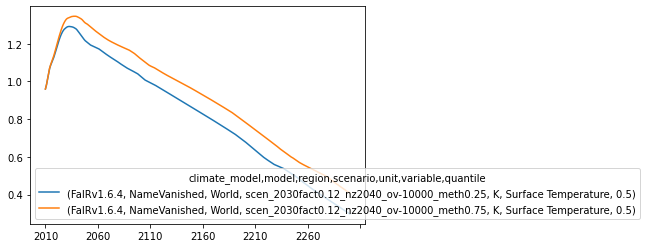

In [63]:
illustrative_scens = ["scen_2030fact0.12_nz2040_ov-10000_meth0.25", "scen_2030fact0.12_nz2040_ov-10000_meth0.75"]
runs_quantiles.loc[
    (runs_quantiles.index.get_level_values("quantile")==0.5) & 
    [s in illustrative_scens for s in runs_quantiles.index.get_level_values("scenario")],
].T.plot()

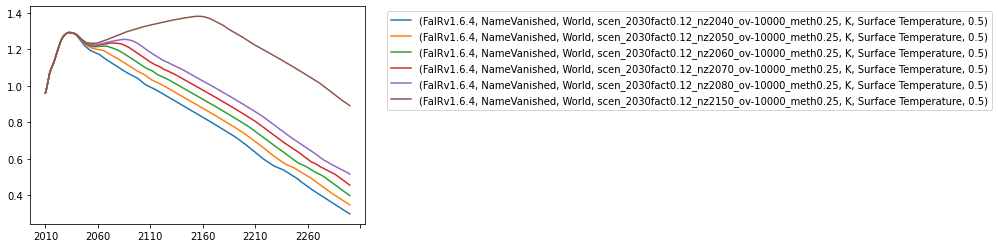

In [64]:
illustrative_scens = [
    "scen_2030fact0.12_nz2040_ov-10000_meth0.25", 
    "scen_2030fact0.12_nz2050_ov-10000_meth0.25",
    "scen_2030fact0.12_nz2060_ov-10000_meth0.25",
    "scen_2030fact0.12_nz2070_ov-10000_meth0.25",
    "scen_2030fact0.12_nz2080_ov-10000_meth0.25",
    "scen_2030fact0.12_nz2150_ov-10000_meth0.25",
]
ax=plt.subplot(111)
runs_quantiles.loc[
    (runs_quantiles.index.get_level_values("quantile")==0.5) & 
    [s in illustrative_scens for s in runs_quantiles.index.get_level_values("scenario")],
].T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1))

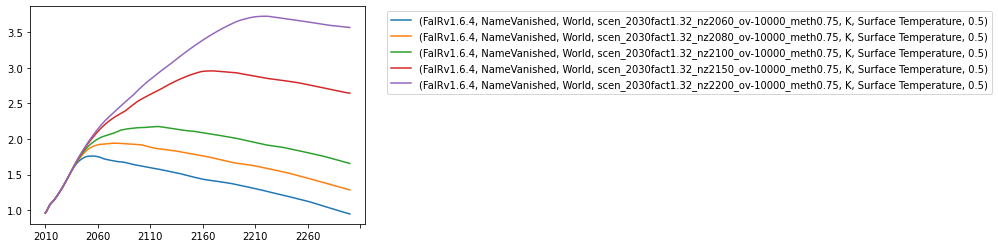

In [66]:
illustrative_scens = [
    "scen_2030fact1.32_nz2200_ov-10000_meth0.75", 
    "scen_2030fact1.32_nz2150_ov-10000_meth0.75",
    "scen_2030fact1.32_nz2100_ov-10000_meth0.75",
    "scen_2030fact1.32_nz2080_ov-10000_meth0.75",
    "scen_2030fact1.32_nz2060_ov-10000_meth0.75",
    "scen_2030fact1.32_nz2040_ov-10000_meth0.75",
]
ax=plt.subplot(111)
runs_quantiles.loc[
    (runs_quantiles.index.get_level_values("quantile")==0.5) & 
    [s in illustrative_scens for s in runs_quantiles.index.get_level_values("scenario")],
].T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1))

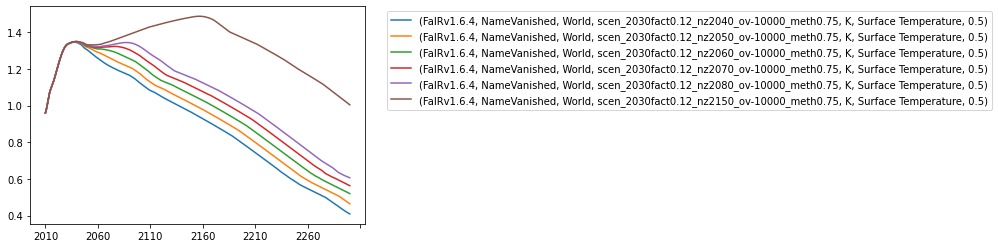

In [65]:
illustrative_scens = [
    "scen_2030fact0.12_nz2040_ov-10000_meth0.75", 
    "scen_2030fact0.12_nz2050_ov-10000_meth0.75",
    "scen_2030fact0.12_nz2060_ov-10000_meth0.75",
    "scen_2030fact0.12_nz2070_ov-10000_meth0.75",
    "scen_2030fact0.12_nz2080_ov-10000_meth0.75",
    "scen_2030fact0.12_nz2150_ov-10000_meth0.75",
]
ax=plt.subplot(111)
runs_quantiles.loc[
    (runs_quantiles.index.get_level_values("quantile")==0.5) & 
    [s in illustrative_scens for s in runs_quantiles.index.get_level_values("scenario")],
].T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1))

In [67]:
runs_quantiles_xr = runs_quantiles.to_xarray()

In [68]:
runs_quantiles_xr["quantile"] = [str(x.values) for x in runs_quantiles_xr["quantile"][:]]

In [78]:
runs_summary.to_csv(
    '{}fair_output_summary_{}_{}.csv'.format(output_dir, date_str, version)
)

In [79]:
runs_quantiles_xr.to_netcdf(
    '{}fair_output_quantiles_{}_{}.nc'.format(output_dir, date_str, version)
)

In [80]:
runs_quantiles.to_csv('{}fair_output_quantiles_{}_{}.csv'.format(output_dir, date_str, version))